In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

ys = np.array([0.,0.05, 0.1 ,0.2 ,0.3 ,0.5 ,1.,2.,3.,5.,8.,10 ,12 ,15 ,20])
rhos = np.array([1.225,1.219,1.213,1.202,1.190,1.167,1.112,1.007,0.909,0.736,0.526,0.414,0.312,0.195,0.089])
z = np.polyfit(ys, rhos, 4)

z

array([ 3.33121912e-06, -1.67661954e-04,  5.15632148e-03, -1.19537867e-01,
        1.22544656e+00])

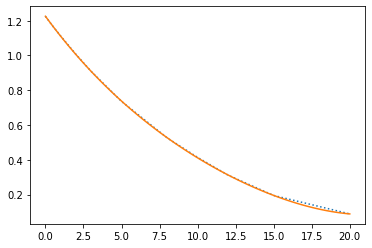

In [2]:
import matplotlib.pyplot as plt

plt.plot(ys, rhos, ':')
xs = np.linspace(ys[0], ys[-1],100)
plt.plot(xs, z[0]*xs**4 + z[1]*xs**3 + z[2]*xs**2 + z[3]*xs + z[4])

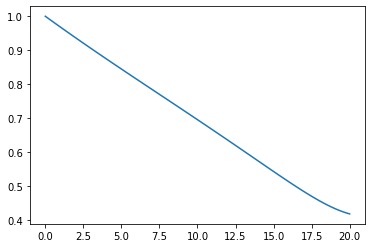

In [3]:
plt.plot(xs, ((z[0]*xs**4 + z[1]*xs**3 + z[2]*xs**2 + z[3]*xs + z[4])/z[4])**(1/3))

In [4]:
from cydrone.drone import Drone2d
from easyvec import Vec2

<frozen importlib._bootstrap>:219: RuntimeWarning: easyvec.vectors.Vec3 size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject


In [5]:
def get_zz(F1, F2):

    drone = Drone2d.get_DJI()
    d = drone.to_dict()
    d['alpha'] = 0 * 3.14/180
    drone.from_dict(d)
    drone.g = 9.81
    dcts = [d]
    for i in range(300):
        drone.step(F1, F2, 0.01, 10)
        d = drone.to_dict()
        dcts.append(d)
    return dcts

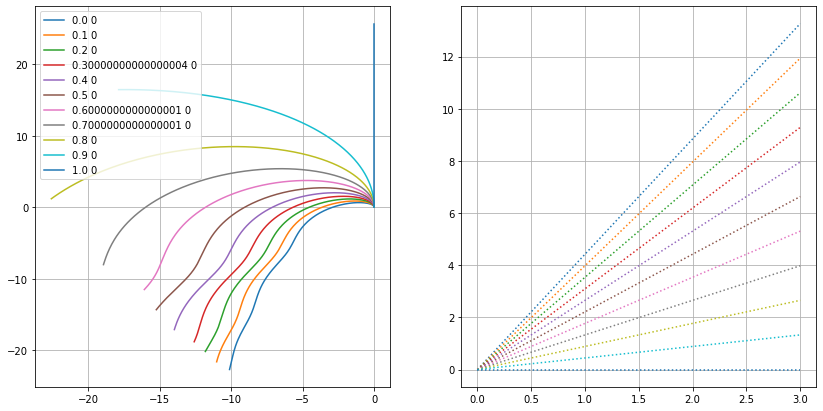

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
for F1 in np.linspace(0,1,11):
    dcts = get_zz(F1, 1)
    xs = [d['pos'].x for d in dcts]    
    ys = [d['pos'].y for d in dcts]    
    ax1.plot(xs, ys, label=f'{F1} 0')
    
    ts = [d['t'] for d in dcts]   
    ass = [d['alpha'] for d in dcts]   
    oms = [d['omega'] for d in dcts]   
#     ax2.plot(ts, ass, label=f'alpha {F1}')
    ax2.plot(ts, oms, ls=':', label=f'omegas {F1}')
ax1.legend()
ax1.grid()
ax2.grid()
plt.show()

In [7]:
15/3.14/2

2.3885350318471334

In [8]:
50**2 * 3.14 / 4 * 6000 / 10**9 * 7800

91.845

In [9]:
drone = Drone2d.get_DJI()
d = drone.to_dict()
d['vel'] = Vec2(-10,
                0)
drone.from_dict(d)

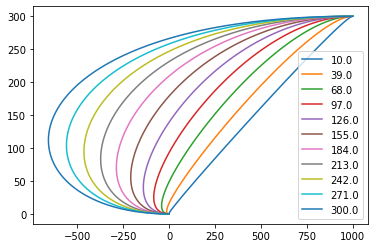

In [10]:
for t in np.linspace(10,300, 11):
    tr = drone.get_traject(t, (1000, 300), (20,0))
    plt.plot(tr[:,0], tr[:,1], label=f'{t}')
plt.legend()

(3.0965623518540286, 50.95107228484312, 6.9602043392737)


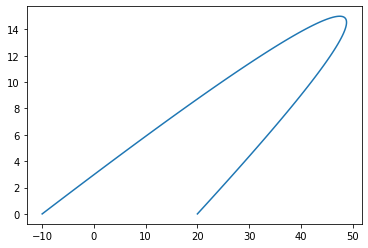

In [11]:
tr = drone.get_traject_vels(30, (1000, 300), (20,0))
print(drone.get_vmin_vmax_amax(30, Vec2(1000, 300), Vec2(20,0)))
plt.plot(tr[:,0], tr[:,1])

In [12]:
from scipy.optimize import minimize

In [13]:
def denorm(x, drone, pos_trg, vel_trg_len, a_max):
    delta_t, alpha_trg = x
    vA = drone.vel
    t1 = (pos_trg-drone.pos).len() / (0.5 * (vel_trg_len + vA.len()))
    delta_t = delta_t * t1
    return delta_t, alpha_trg

def minim_foo(x, drone, pos_trg, vel_trg_len, a_max, v_max):
    delta_t, alpha_trg = denorm(x, drone, pos_trg, vel_trg_len, a_max)
    if delta_t < 1e-6:
        return 1e10
    vA = drone.vel
    vel_trg = Vec2(vel_trg_len, 0).rotate(alpha_trg)
    vmin ,vmax, amax = drone.get_vmin_vmax_amax(delta_t, pos_trg, vel_trg)
    shtraf = 1
    vminAD = min(vA.len(), vel_trg_len) * 0.5
    vmaxAD = max(vA.len(), vel_trg_len, v_max) 
    if vmin < vminAD:
        shtraf += 10
    if vmax > vmaxAD:
        shtraf += 10
    if amax > a_max:
        shtraf += 10
    return delta_t * shtraf
    

In [14]:
pos_trg = Vec2(100, 200)
vel_trg_len =1
a_max = 13
v_max = 30
res = minimize(minim_foo, (1,0), args=(drone, pos_trg, vel_trg_len, a_max, v_max),method='Nelder-Mead', options={
    'maxfev': 42,
    'initial_simplex': np.array([[1,0], [1.5, -1], [0.5, 1]])
})
res

 final_simplex: (array([[0.28465176, 1.43069649],
       [0.28475952, 1.43048096],
       [0.28530431, 1.42939138]]), array([11.57273958, 11.57712086, 11.59926958]))
           fun: 11.572739581301597
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 43
           nit: 21
        status: 1
       success: False
             x: array([0.28465176, 1.43069649])

In [15]:
# %%timeit 
# res = minimize(minim_foo, (1,0), args=(drone, pos_trg, vel_trg_len, a_max, v_max),method='Nelder-Mead', options={ 
#     'maxfev': 42,
#     'initial_simplex': np.array([[1,0], [1.5, -1], [0.5, 1]])
# })

In [16]:
delta_t, alpha_trg = denorm(res.x, drone,  pos_trg, vel_trg_len, a_max)

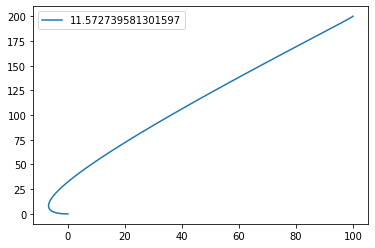

In [17]:
tr = drone.get_traject(delta_t, pos_trg, Vec2(vel_trg_len,0).rotate(alpha_trg))
plt.plot(tr[:,0], tr[:,1], label=f'{delta_t}')
plt.legend()

(0.9999999999999989, 29.98528263071749, 11.825764343837765)


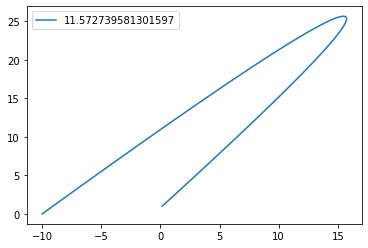

In [18]:
tr = drone.get_traject_vels(delta_t, pos_trg, Vec2(vel_trg_len,0).rotate(alpha_trg))
plt.plot(tr[:,0], tr[:,1], label=f'{delta_t}')
print(drone.get_vmin_vmax_amax(delta_t, pos_trg, Vec2(vel_trg_len,0).rotate(alpha_trg)))
plt.legend()

In [19]:
from easyvec import Mat2

In [20]:
np.array([(1,0), (1,0), (1,1)]) @ np.asarray(Mat2.from_angle(0.3).as_np())

array([[0.95533649, 0.29552021],
       [0.95533649, 0.29552021],
       [0.65981628, 1.2508567 ]])

In [21]:
drone.to_numpy()

array([  0.,   0., -10.,   0.,   0.,   0.,   0.])

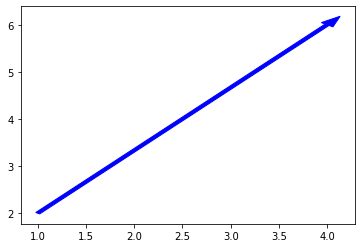

In [22]:
plt.arrow(1,2,3,4,color='blue', width=0.05)

In [23]:
dict(dict(a=1, b=3), **{'a': 33})

{'a': 33, 'b': 3}

In [24]:
from drone_gym import DroneGym

In [230]:
gym = DroneGym.make('ha')

In [285]:
observation_ = gym.reset()
gym.antiflip = True

In [286]:
import numpy as np

In [287]:
done = False
gym.record_history = True
i = 0
while not done and i < 2000:
#     observation_, reward, done, info = gym.step(np.random.uniform(0.99,1, size=2))
    observation_, reward, done, info = gym.step(agent.choose_action(observation_))
    i += 1

In [288]:
from ipywidgets import interact, interactive, fixed
import ipywidgets

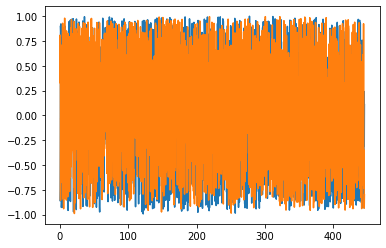

In [289]:
xs = []
ys = []
f1s = []
f2s = []
rewards = []
ts = []
dts = []
scores = [0]
for d in gym.history:
    gym.set_state(d['state'])
    xs.append(gym.drone.pos.x)
    ys.append(gym.drone.pos.y)
    f1, f2 = d['actions']
    f1s.append(f1)
    f2s.append(f2)
    ts.append(gym.time_curr)
    rewards.append(d['reward'])
    dts.append(d['delta_t1'])
    scores.append(scores[-1]+d['reward'])
scores = scores[1:]
i1=0
i2=-1
# plt.plot(ts[i1:i2], rewards[i1:i2])
plt.plot(ts[i1:i2], f1s[i1:i2])
plt.plot(ts[i1:i2], f2s[i1:i2])
# plt.plot(ts[i1:i2], dts[i1:i2])

In [291]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(gym.history)-1,step=1, value=0))
def plot_history(i):
    d = gym.history[i]
    i1=0#max(0,i-30)
    i2=i+1
    gym.set_state(d['state'])
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
    gym.plot(ax, drone_mashtb=20, vec_mashtb=1, actions=d['actions'],ideal_traj=True)
    ax.plot(xs[i1:i],ys[i1:i],ls=':')
    ax.set_aspect('equal', adjustable='box')
    
    
#     ax2.plot(ts[i1:i2], f1s[i1:i2])
#     ax2.plot(ts[i1:i2], f2s[i1:i2])
    ax2.grid()
    ax2.plot(ts[i1:i2], scores[i1:i2])
    
    ax3.plot(ts[i1:i2], rewards[i1:i2])
    ax3.grid()
    ax.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=1783), Output()), _dom_classes=('widget-interact…

In [31]:
import torch as T

In [32]:
T.cuda.is_available()

True

In [33]:
import gym
import pybullet_envs

In [442]:
env = gym.make('InvertedPendulumBulletEnv-v0')

D:\neuro_missile\env_neuro_missile\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [34]:
import numpy as np

# Обучение

In [35]:
from drone_sac import Agent
from drone_gym import DroneGym
from tqdm.notebook import tqdm

In [185]:
env = DroneGym.make('ww')

In [94]:

agent = Agent(env = env, input_dims=env.obs_max.shape)

In [275]:
score = 0
env.record_history = True
for i in tqdm(range(250)):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, done)
#         if not load_checkpoint:
        agent.learn()
        observation = observation_

#     print('episode ', i, 'score %.1f' % score)

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [277]:
for i in tqdm(range(100)):
    agent.learn()

  0%|          | 0/100 [00:00<?, ?it/s]

In [272]:
agent.batch_size = 2048 * 2

In [276]:
agent.memory.mem_cntr

592548

In [237]:
from easyvec import Vec2

In [263]:
A = Vec2(0,0)
Va = Vec2(5,5)

D = Vec2(11,10)
Vd_len = 1

In [264]:
ts = np.linspace(1,10)
Vd_facts = []
for t in ts:
    Z = A + t*Va/2
    
    Vd_facts.append((Z-D).len()*2 /t)

In [265]:
Vd_facts

[22.67156809750927,
 18.058597973292358,
 14.685186805656974,
 12.111011221107178,
 10.082249982314583,
 8.442305461361991,
 7.089333418415747,
 5.9542526819072785,
 4.988573789331827,
 4.15729201801809,
 3.434556786825559,
 2.8009507412277905,
 2.241766775693562,
 1.745990575284539,
 1.3059862173851604,
 0.9185264973183906,
 0.5906281229671688,
 0.3679386965556837,
 0.37178878971479035,
 0.5545454545454557,
 0.777660479147047,
 1.0000000000000007,
 1.21237317309727,
 1.4127670170736752,
 1.6011476837894685,
 1.7781027890641785,
 1.9444070947638359,
 2.100864810446717,
 2.2482491234617585,
 2.3872798534849995,
 2.518617112557652,
 2.6428618801048085,
 2.7605594984147,
 2.8722042555458804,
 2.978244198225697,
 3.0790857784039134,
 3.1750981619272,
 3.266617139065502,
 3.3539486314219666,
 3.4373718157918267,
 3.517141896720905,
 3.593492563039848,
 3.6666381633024367,
 3.7367756328540875,
 3.804086202278328,
 3.868736913784516,
 3.9308819690013066,
 3.990663928766555,
 4.048214782911534

In [259]:
Va.len()

11.180339887498949